In [1]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
import pymoo.gradient.toolbox as anp
from pymoo.optimize import minimize
import matplotlib.pyplot as plt
import scienceplots
import numpy as np

# ZDT1

In [23]:
class ZDT(Problem):

    def __init__(self, n_var=30, **kwargs):
        super().__init__(n_var=n_var, n_obj=1, xl=0, xu=1, vtype=float, **kwargs)

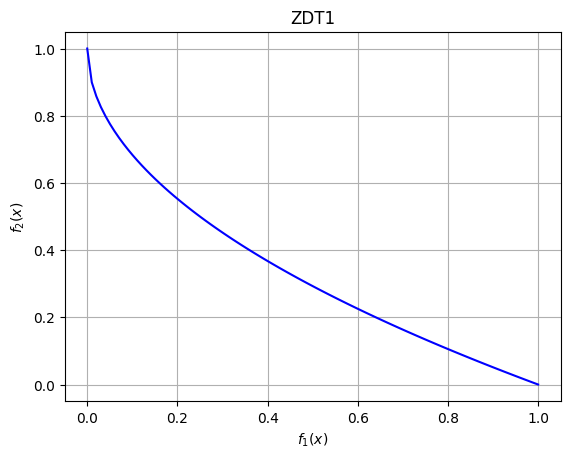

In [2]:
# 凸なパレートフロントを持つ問題
problem = get_problem("zdt1", n_var=30)

# 問題の可視化
def plot(problem, solv=None, save_name=None):
    if solv is not None:
        plt.scatter(solv[:, 0], solv[:, 1], color='red')
    ans = problem.pareto_front()
    plt.plot(ans[:, 0], ans[:, 1], color='blue')
    plt.title(problem.name())
    plt.xlabel("$f_1(x)$")
    plt.ylabel("$f_2(x)$")
    plt.grid(True)
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()



plot(problem, save_name="zdt1_pareto_front.png")

## 重み付き線形和

In [21]:
# linear weight sum method
#各重みについてF(x)=w1*f1(x)+w2*f2(x)を最小化
#最適化アルゴリズムにはGAを使用

class ZDT1_single_linear(ZDT):

    def __init__(self, weights, n_var=30, **kwargs):
        super().__init__(**kwargs)
        self.weights = weights

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1 + 9.0 / (self.n_var - 1) * anp.sum(x[:, 1:], axis=1)
        f2 = g * (1 - anp.power((f1 / g), 0.5))

        f = self.weights[0] * f1 + self.weights[1] * f2

        out["F"] = anp.column_stack([f])

def linear_weight_sum_method(problem, weights):
    F = []
    points = []
    for w in weights:
        problem_single = ZDT1_single_linear(w, n_var=30)
        res = minimize(problem_single, GA(), termination=('n_gen', 100))
        F.append(res.F)
        points.append(res.X)

    F = np.row_stack(F)
    points = np.row_stack(points)

    return (F, points)


weights1 = np.linspace(0, 1, 100)
weights = np.column_stack([weights1, 1 - weights1])
F, points = linear_weight_sum_method(problem, weights)

C:\Users\daiki\AppData\Local\Temp\ipykernel_24628\3997806735.py:14: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  F = np.row_stack(F)
C:\Users\daiki\AppData\Local\Temp\ipykernel_24628\3997806735.py:15: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  points = np.row_stack(points)


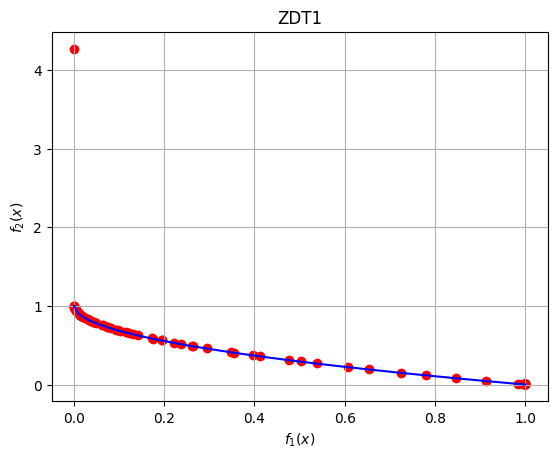

In [22]:
solv = problem.evaluate(points)
plot(problem, solv, save_name="zdt1_linear_weight_sum_method.png")


## チャビシェフスカラー化

In [25]:
# チャビシェフスカラー化
#最適化アルゴリズムにはGAを使用
class ZDT1_single_cheb(ZDT):
    def __init__(self, weights, n_var=30, **kwargs):
        super().__init__(**kwargs)
        self.weights = weights

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1 + 9.0 / (self.n_var - 1) * anp.sum(x[:, 1:], axis=1)
        f2 = g * (1 - anp.power((f1 / g), 0.5))

        f = np.maximum(self.weights[0] * f1, self.weights[1] * f2)
        out["F"] = anp.column_stack([f])

def chebyshev_scalarization(problem, weights):
    F = []
    points = []
    for w in weights:
        problem_single = ZDT1_single_cheb(w, n_var=30)
        res = minimize(problem_single, GA(), termination=('n_gen', 100))
        F.append(res.F)
        points.append(res.X)

    F = np.row_stack(F)
    points = np.row_stack(points)

    return (F, points)


weights1 = np.linspace(0, 1, 100)
weights = np.column_stack([weights1, 1 - weights1])
F, points = chebyshev_scalarization(problem, weights)

C:\Users\daiki\AppData\Local\Temp\ipykernel_24628\405750784.py:29: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  F = np.row_stack(F)
C:\Users\daiki\AppData\Local\Temp\ipykernel_24628\405750784.py:30: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  points = np.row_stack(points)


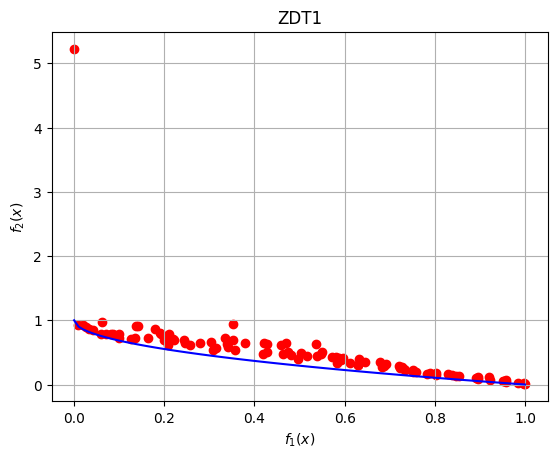

In [26]:
solv = problem.evaluate(points)
plot(problem, solv, save_name="zdt1_chebyshev_scalarization.png")

## 拡大チャビシェフスカラー化

In [27]:
# チャビシェフスカラー化
#最適化アルゴリズムにはGAを使用
class ZDT1_single_augcheb(ZDT):
    def __init__(self, weights, n_var=30, **kwargs):
        super().__init__(**kwargs)
        self.weights = weights

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1 + 9.0 / (self.n_var - 1) * anp.sum(x[:, 1:], axis=1)
        f2 = g * (1 - anp.power((f1 / g), 0.5))

        f = 0.001 * (self.weights[0] * f1 + self.weights[1] * f2)
        f += np.maximum(self.weights[0] * f1, self.weights[1] * f2)
        out["F"] = anp.column_stack([f])

def augmented_chebyshev_scalarization(problem, weights):
    F = []
    points = []
    for w in weights:
        problem_single = ZDT1_single_augcheb(w, n_var=30)
        res = minimize(problem_single, GA(), termination=('n_gen', 100))
        F.append(res.F)
        points.append(res.X)

    F = np.row_stack(F)
    points = np.row_stack(points)

    return (F, points)


weights1 = np.linspace(0, 1, 100)
weights = np.column_stack([weights1, 1 - weights1])
F, points = augmented_chebyshev_scalarization(problem, weights)

C:\Users\daiki\AppData\Local\Temp\ipykernel_24628\288766084.py:30: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  F = np.row_stack(F)
C:\Users\daiki\AppData\Local\Temp\ipykernel_24628\288766084.py:31: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  points = np.row_stack(points)


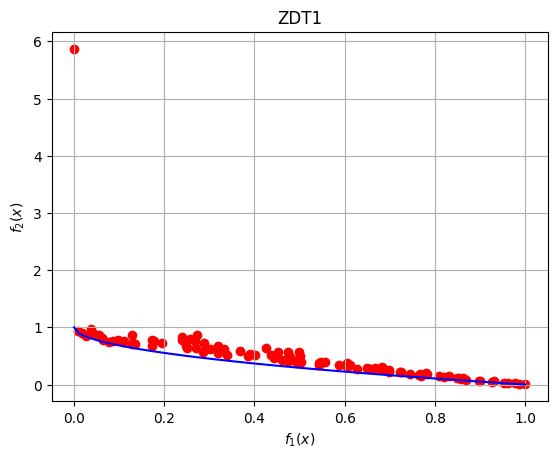

In [28]:
solv = problem.evaluate(points)
plot(problem, solv, save_name="zdt1_augmented_chebyshev_scalarization.png")

# CTP6